librairies

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

%matplotlib inline
sns.set(style="whitegrid")

DB_HOST = os.getenv("DB_HOST", "localhost")
PG_URI = f"postgresql://user:password@{DB_HOST}:5432/athlete_db"

print(f" Configuration : Connexion à {DB_HOST}...")

 Configuration : Connexion à localhost...


Connexion à la Base de Données (PostgreSQL)

In [3]:
try:
    engine = create_engine(PG_URI)

    # Jointure GPS + Médical
    query = """
    SELECT 
        g.date,
        g.player_id,
        g.total_distance_m,
        g.hsr_distance_m,
        g.max_speed_kmh,
        m.age,
        m.weight_kg,
        m.injury_history_index,
        m.last_vma_test
    FROM gps_metrics g
    JOIN medical_info m ON g.player_id = m.player_id
    """

    df = pd.read_sql(query, engine)
    
    print(f"Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    display(df.head())

except Exception as e:
    print(f" Erreur de connexion : {e}")
    print(" Vérifie que tes conteneurs Docker tournent (docker ps)")

Dataset chargé : 2849965 lignes, 9 colonnes


,date,player_id,total_distance_m,hsr_distance_m,max_speed_kmh,age,weight_kg,injury_history_index,last_vma_test
0,2026-01-01,Player_4,6979.60,231.90,29.65,29,82,0,17.2
1,2026-01-01,Player_6,5038.38,295.00,26.18,23,92,4,17.4
2,2026-01-01,Player_8,6172.92,333.17,27.87,30,91,2,14.6
3,2026-01-01,Player_9,6266.09,347.86,28.48,24,79,2,17.5
4,2026-01-01,Player_10,6065.77,317.19,28.11,33,86,4,19.1


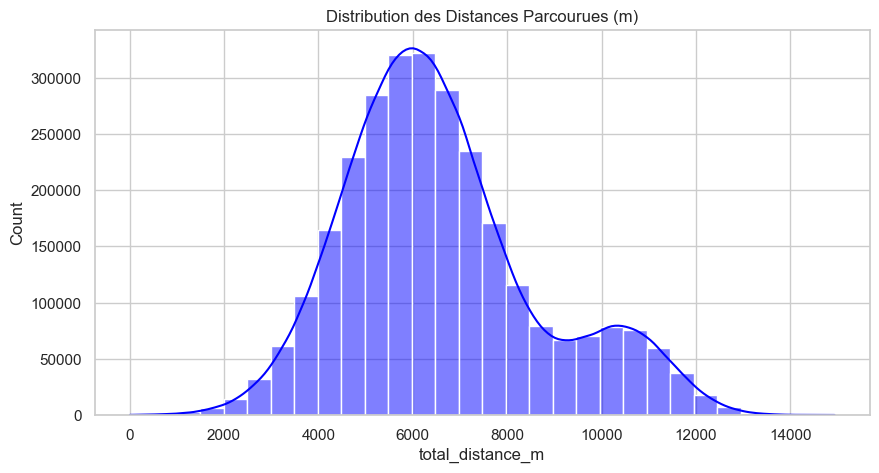

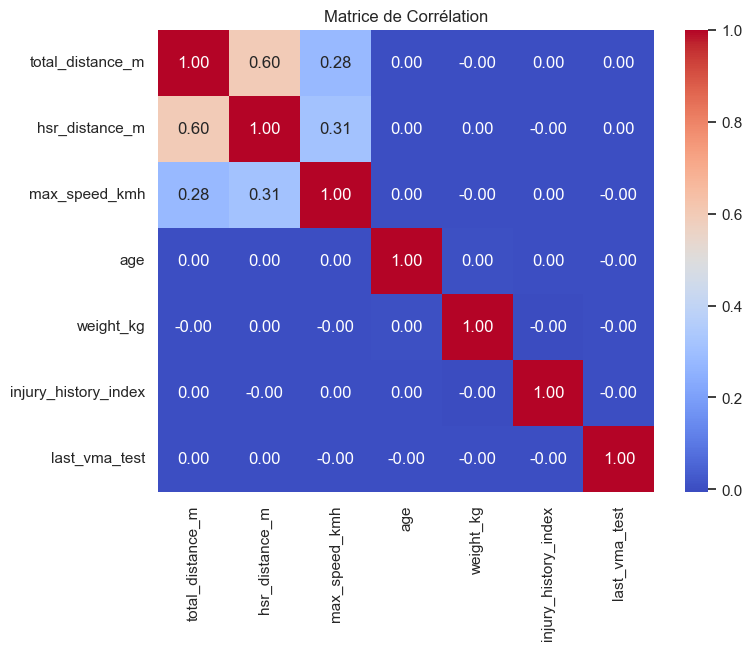

In [4]:
if not df.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(df['total_distance_m'], bins=30, kde=True, color='blue')
    plt.title("Distribution des Distances Parcourues (m)")
    plt.show()

    # Corrélation
    plt.figure(figsize=(8, 6))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matrice de Corrélation")
    plt.show()

 Taux de blessure généré : 19.5%


/var/folders/_w/2g7vjxdx75x4_ffs2rltwwv00000gn/T/ipykernel_42588/344752914.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_risk', data=df_model, palette='Set2')


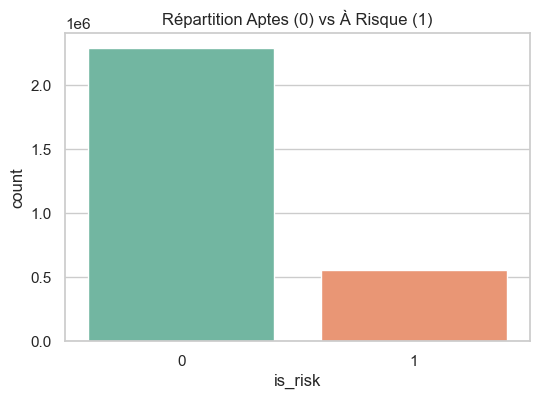

In [5]:
def create_realistic_target(df):
    """
    Génère une colonne 'is_risk' basée sur des probabilités
    pour éviter d'avoir 100% de joueurs aptes.
    """
    # Simulation ACWR (Charge Aiguë vs Chronique)
    df['acwr_simulated'] = df['total_distance_m'] / 7500 
    
    risk_prob = 0.05 
    
    risk_prob += np.where(df['acwr_simulated'] > 1.3, 0.30, 0.0) # Surcharge
    risk_prob += np.where(df['hsr_distance_m'] > 800, 0.20, 0.0) # Trop de sprint
    risk_prob += np.where(df['injury_history_index'] > 2, 0.15, 0.0) # Fragile
    risk_prob += np.where(df['age'] > 30, 0.10, 0.0) # Âge

    # Plafond à 95%
    risk_prob = np.clip(risk_prob, 0, 0.95)
    
    # Tirage aléatoire (0 ou 1) selon la probabilité
    df['is_risk'] = np.random.binomial(1, risk_prob)
    
    return df

df_model = create_realistic_target(df.copy())

risk_counts = df_model['is_risk'].value_counts(normalize=True)
print(f" Taux de blessure généré : {risk_counts.get(1, 0):.1%}")

plt.figure(figsize=(6, 4))
sns.countplot(x='is_risk', data=df_model, palette='Set2')
plt.title("Répartition Aptes (0) vs À Risque (1)")
plt.show()

In [6]:
features = [
    'total_distance_m', 'hsr_distance_m', 'max_speed_kmh', 
    'age', 'weight_kg', 'injury_history_index', 'last_vma_test'
]

X = df_model[features]
y = df_model['is_risk']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

print(" Modèle entraîné avec succès.")

 Modèle entraîné avec succès.


 Précision globale (Accuracy) : 82.19%

              precision    recall  f1-score   support

           0       0.84      0.97      0.90    458986
           1       0.62      0.22      0.32    111007

    accuracy                           0.82    569993
   macro avg       0.73      0.59      0.61    569993
weighted avg       0.79      0.82      0.79    569993



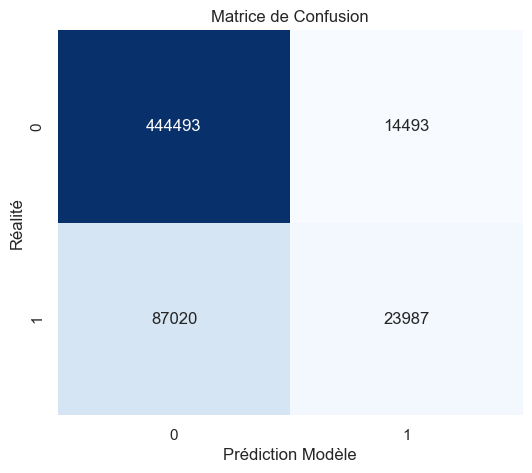

In [7]:
y_pred = clf.predict(X_test)

# Métriques
acc = accuracy_score(y_test, y_pred)
print(f" Précision globale (Accuracy) : {acc:.2%}\n")
print(classification_report(y_test, y_pred))

# Matrice de Confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prédiction Modèle')
plt.ylabel('Réalité')
plt.title('Matrice de Confusion')
plt.show()

/var/folders/_w/2g7vjxdx75x4_ffs2rltwwv00000gn/T/ipykernel_42588/30979536.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable', data=importances, palette='viridis')


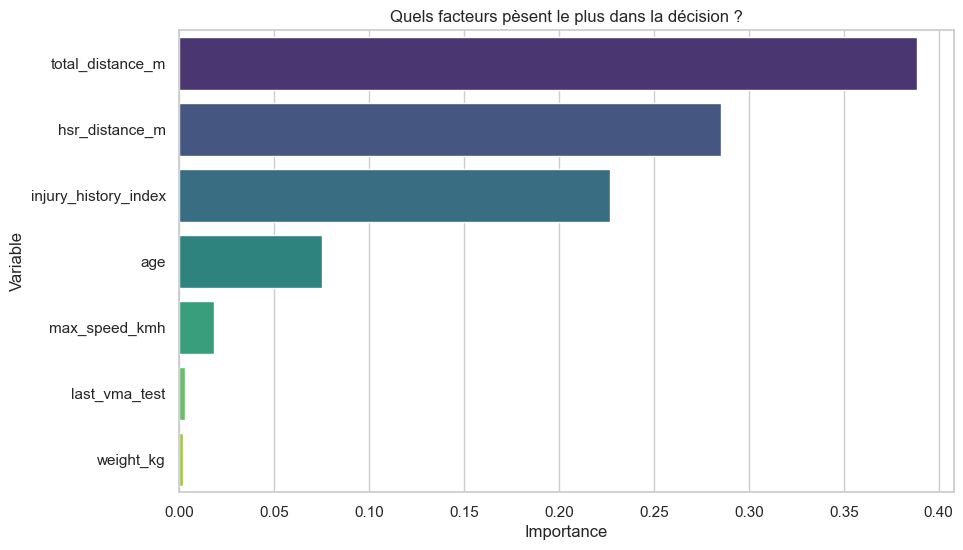

 Modèle sauvegardé et prêt pour l'API : ../models/injury_risk_model.pkl


In [8]:
importances = pd.DataFrame({
    'Variable': features,
    'Importance': clf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=importances, palette='viridis')
plt.title("Quels facteurs pèsent le plus dans la décision ?")
plt.show()


os.makedirs('../models', exist_ok=True)
model_path = '../models/injury_risk_model.pkl'

joblib.dump(clf, model_path)
print(f" Modèle sauvegardé et prêt pour l'API : {model_path}")